# Single Molecule Counting Perspective Figures

In [21]:
import msions.encyclopedia as encyclo
import msions.mzml as mzml
import msions.hardklor as hk
import msions.kronik as kro
import msions.msplot as msplot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter  # format decimal places
import pymzml
import sqlite3
import math

In [22]:
# create DataFrame from elib
ev_encyclo_df = encyclo.dia_df("panoramaweb_files/plasma-EV-01.mzML.elib")

In [23]:
# create DataFrame from mzML
ev_ms1_df = mzml.tic_df("panoramaweb_files/plasma-EV-01.mzML")

In [24]:
# create DataFrame from Hardklor output
ev_hk_df = hk.hk2df("panoramaweb_files/plasma-EV-01_MS1_3sn.hk")
ev_hk_df["rt_s"] = ev_hk_df["rt"]*60
ev_hk_df['mz'] = ev_hk_df["mz"].round(4)

#summarize Hardklor DataFrame
summed_ev_hk = hk.summarize_df(ev_hk_df, full_ms1_df=ev_ms1_df)

In [25]:
#find hardklor retention time/charge/mass match in encyclopeDIA
# redo - remove after module
def match_hk(ref_row, other_df):
    mz2match = ref_row.mz
    charge2match = ref_row.charge
    rt2match = ref_row.rt_s
    
    small_df = other_df
    
    small_df = small_df.loc[(small_df.RTInSecondsStart <= rt2match) & (small_df.RTInSecondsStop >= rt2match) & (small_df.PrecursorCharge == charge2match)]
    
    small_df = small_df[np.isclose(small_df.PrecursorMz, mz2match, rtol=5e-6)]
    
    return(small_df.shape[0])

In [26]:
# find Hardklor retention time/charge/mass match in encyclopeDIA results
# redo with module later
ev_hk_df["in_encyclo"] = ev_hk_df.apply(match_hk, axis=1, other_df=ev_encyclo_df)

In [27]:
# create DataFrame of only identified features
# redo with module later
id_ev_hk_df = ev_hk_df[ev_hk_df["in_encyclo"] > 0].reset_index(drop=True)

In [28]:
# summarize identified features DataFrame
# redo with module later
sum_id_ev_hk_df = hk.summarize_df(id_ev_hk_df, full_ms1_df=ev_ms1_df)

In [29]:
# find total ion current across all 
# redo with module later
print("TIC across all scans:", sum(ev_ms1_df.TIC))
print("in scientific notation: %.2e" % sum(ev_ms1_df.TIC))

TIC across all scans: 10523443416666.562
in scientific notation: 1.05e+13


In [30]:
# find identified total ion current
# redo with module later
print("ID'd TIC:", sum(sum_id_ev_hk_df.TIC))
print("in scientific notation: %.2e" % sum(sum_id_ev_hk_df.TIC))

ID'd TIC: 4882256360885
in scientific notation: 4.88e+12


In [31]:
# calculate ratio of identified ion current to total ion current
# redo with module later
print("ID'd TIC / all TIC =", sum(sum_id_ev_hk_df.TIC)/sum(ev_ms1_df.TIC))

ID'd TIC / all TIC = 0.46394095236476485


In [32]:
# find number of ions across all scans
# redo with module later
print("ions across all scans:", sum(ev_ms1_df.ions))
print("in scientific notation: %.2e" % sum(ev_ms1_df.ions))

ions across all scans: 5057320876.676819
in scientific notation: 5.06e+09


In [33]:
# find number of identified 
# redo with module later
print("ID'd ions:", sum(sum_id_ev_hk_df.ions))
print("in scientific notation: %.2e" % sum(sum_id_ev_hk_df.ions))

ID'd ions: 1219880662.2828493
in scientific notation: 1.22e+09


In [34]:
# calculate ratio of identified ions to total ions
# redo with module later
print("ID'd ions / all ions =", sum(sum_id_ev_hk_df.ions)/sum(ev_ms1_df.ions))

ID'd ions / all ions = 0.24121084899094572


In [35]:
# join DataFrames
# redo with module later
joined_EV = pd.merge(ev_ms1_df, sum_id_ev_hk_df, how="outer", on=["scan_num"], suffixes=("_ms1","_id"))

## Figure (a)

In [36]:
# create run object
run = pymzml.run.Reader("panoramaweb_files/plasma-EV-01.mzML")

In [37]:
# initiate peak dictionary
peak_dict = {}

# initiate peak DataFrame
peak_df = pd.DataFrame(columns=["mz", "ips", "rt"])

# loop through spectra
for spectra in run:
    if spectra.ms_level == 1:
        peak_array = pd.DataFrame(spectra.peaks("centroided")).rename(columns={0: "mz", 1: "ips"})
        peak_array["mz"] = peak_array["mz"].round(4)
        peak_array["rt"] = spectra.scan_time[0]
        peak_df = pd.concat([peak_df, peak_array])
        peak_dict[spectra.ID] = peak_array

In [38]:
# function to create a bin list
def create_bin_list(start,end,bin_size,bin_mult):
    
    bin_list = []

    for num in np.arange(start,math.ceil(end+(bin_mult-1)*end+1),bin_size*bin_mult):
        bin_list.append(num)

    return bin_list

In [39]:
# function to bin data
def bin_data(df, type, bin_rt_list=None, bin_mz_list=None):
    if type == "rt":
        # create bin column
        df['bin_rt'] = pd.cut(df.rt, bin_rt_list, right=False)
        # sum intensities into bins
        df_binned = df.groupby(['mz','bin_rt'], as_index=False)[['ips']].sum()       
    
    elif type == "mz":
        # create bin column
        df['bin_mz'] = pd.cut(df.mz, bin_mz_list, right=False)
        # sum intensities into bins
        df_binned = df.groupby(['rt','bin_mz'], as_index=False)[['ips']].sum()
    
    elif type == "both":
        # create bin columns
        df['bin_rt'] = pd.cut(df.rt, bin_rt_list, right=False)
        df['bin_mz'] = pd.cut(df.mz, bin_mz_list, right=False)
        # sum intensities into bins
        df_binned = df.groupby(['bin_rt','bin_mz'], as_index=False)[['ips']].sum()

    return(df_binned)

In [40]:
# create bins for m/z
mz_bin_size = 4
mz_bin_mult = 1.0005
mz_start = 399
mz_end = 1005

bin_mz_list = create_bin_list(mz_start, mz_end, mz_bin_size, mz_bin_mult)

# create bins for retention time
rt_bin_size = 0.25
rt_bin_mult = 1
rt_start = 0
rt_end = 100

bin_rt_list = create_bin_list(rt_start, rt_end, rt_bin_size, rt_bin_mult)

In [41]:
# create DataFrame with binned m/z and retention time
peak_binned = bin_data(peak_df.copy(), type="both", bin_mz_list=bin_mz_list, bin_rt_list=bin_rt_list)

# create a max cut-off to help with dynamic range
max_binned = peak_binned.copy()
max_binned["ips_max"] = [x if x < 2e9 else 2e9 for x in max_binned["ips"]]

In [42]:
# create a pivot table to make the heatmap
max_pivot_table = pd.pivot_table(max_binned, values='ips_max', index=['bin_mz'],
                                  columns=['bin_rt'], aggfunc=np.sum)

# sort the m/z to make 400 closer to the x-axis
max_pivot_table = max_pivot_table.sort_values(by=['bin_mz'], ascending=False)

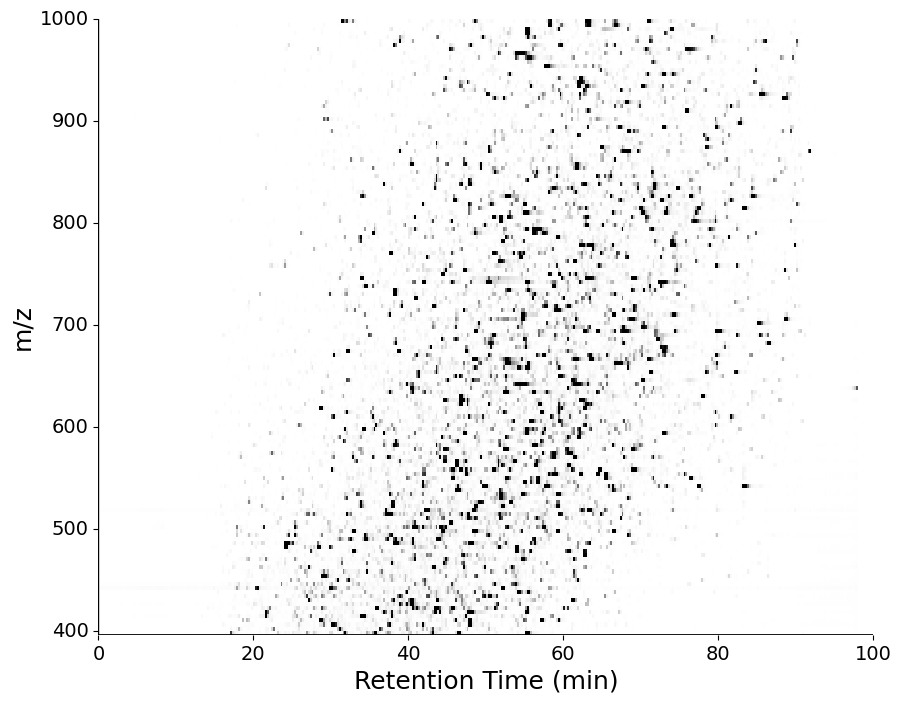

In [43]:
# heatmap for data
fig, ax = plt.subplots(figsize=(10,8))

# create heatmap, remove color bar
# remove last 3 columns because there was no data for those bins
ax = sns.heatmap(max_pivot_table.iloc[:, :-3].astype('float'), cmap='Greys', cbar=False)

# set x-axis parameters
plt.xlabel('Retention Time (min)',fontsize=18)
ax.set_xticks((range(0, len(max_pivot_table.columns), math.floor(len(max_pivot_table.columns)/5))))
ax.set_xticklabels((0,20,40,60,80,100), rotation=0, fontsize=14)
ax.axhline(y=151, color='black', linewidth=2)

# set y-axis parameters
plt.ylabel('m/z',fontsize=18)
ax.set_yticks((range(0, len(max_pivot_table.index), math.floor(len(max_pivot_table.index)/6))))
ax.set_yticklabels((1000,900,800,700,600,500,400), fontsize=14)
ax.axvline(x=0, color='black', linewidth=1)

# show plot
plt.show()

## Figure (b)

In [44]:
# calculate percentage of TIC identified for each scan
perc_id = pd.merge(ev_ms1_df[["rt","TIC"]], sum_id_ev_hk_df[["rt","TIC"]], how="outer", on=["rt"], suffixes=("_ms1","_id"))
perc_id["perc_id"] = perc_id["TIC_id"]/perc_id["TIC_ms1"]
perc_id = perc_id.fillna(0)

In [45]:
# create run object
run = pymzml.run.Reader("panoramaweb_files/plasma-EV-01.mzML")

In [46]:
# choose MS1 spectrum between 40-60 minutes
ms1_spectrum = run[170933]  # 57.6733 min = 3460.398 sec

# create pandas DataFrame of MS1 peaks
ms1_peaks = pd.DataFrame(ms1_spectrum.peaks("centroided")).rename(columns={0: "mz", 1: "ips"})
ms1_peaks["mz"] = ms1_peaks["mz"].round(4)

# create narrow hk_df
peak_hk_df = ev_hk_df[ev_hk_df["rt"] == 57.6733]

In [47]:
# merge identification designation onto MS1 peaks
ms1_peaks = pd.merge_asof(ms1_peaks, peak_hk_df[['mz', 'mass', 'charge', 'in_encyclo']], tolerance=0.001, on=['mz'])
ms1_peaks = ms1_peaks.fillna(-1)

In [48]:
# write algorithm to color peptide isotope distributions
# initiate boolean for being in isotope distribution
in_dist = False

# initiate indices
idx, idx2, idx3 = [0, 0, 0]

# initiate empty lists for previous values
prev_idxs = []

# initiate empty list to be added to DataFrame
in_dist_list = [0]*len(ms1_peaks)

# list to go forward through indices:
fwd_idxs = [x for x in range(0, len(ms1_peaks))]

# loop through whether MS1 peaks were found in Hardklor and encyclopeDIA
for idx, val in enumerate(ms1_peaks["in_encyclo"]):
    # if peak was seen in Hardklor and encyclopeDIA,
    if val >= 1:
        # the peak is in a distribution
        in_dist = True
        in_dist_list[idx] = 1

        # define the mass, mz, and charge of interest
        mono_mass = ms1_peaks.loc[idx, "mass"]
        check_mz = ms1_peaks.loc[idx, "mz"]
        charge_state = ms1_peaks.loc[idx, "charge"]

        # calculate the isotopic difference in mz
        iso_diff = 1/charge_state

        # go back through stored idxs
        for idx2 in reversed(prev_idxs):
            # if the stored idx's mz is within the isotopic difference of the mz of interest
            if np.isclose(ms1_peaks.loc[idx2, "mz"], check_mz-iso_diff, atol=0.01):
                in_dist_list[idx2] = 1
                check_mz = ms1_peaks.loc[idx2, "mz"]
            elif (check_mz+iso_diff)-ms1_peaks.loc[idx3, "mz"] > 2*iso_diff:
                break
                
    if in_dist:
        for idx3 in fwd_idxs[idx+1:]:
            # if the stored idx's mz is within the isotopic difference of the mz of interest
            if np.isclose(ms1_peaks.loc[idx3, "mz"], check_mz+iso_diff, atol=0.01):
                in_dist_list[idx3] = 1
                check_mz = ms1_peaks.loc[idx3, "mz"]    
            elif ms1_peaks.loc[idx3, "mz"]-(check_mz+iso_diff) > 2*iso_diff:
                in_dist = False
                break                
        # if val >= 1: 
            # edge case to be investigated in the future where there is more than 1 distribution

    # if peak was not seen in encyclopeDIA
    else:
        # keep track of seen indices that are not monoisotopic peaks
        prev_idxs.append(idx)

# add the column to the ms1_peaks DataFrame
ms1_peaks["in_dist"] = in_dist_list

In [49]:
# create DataFrames of identified and non-identified peaks
id_ms1_peaks = ms1_peaks[ms1_peaks["in_dist"] > 0].reset_index(drop=True)
noid_ms1_peaks = ms1_peaks[ms1_peaks["in_dist"] == 0].reset_index(drop=True)

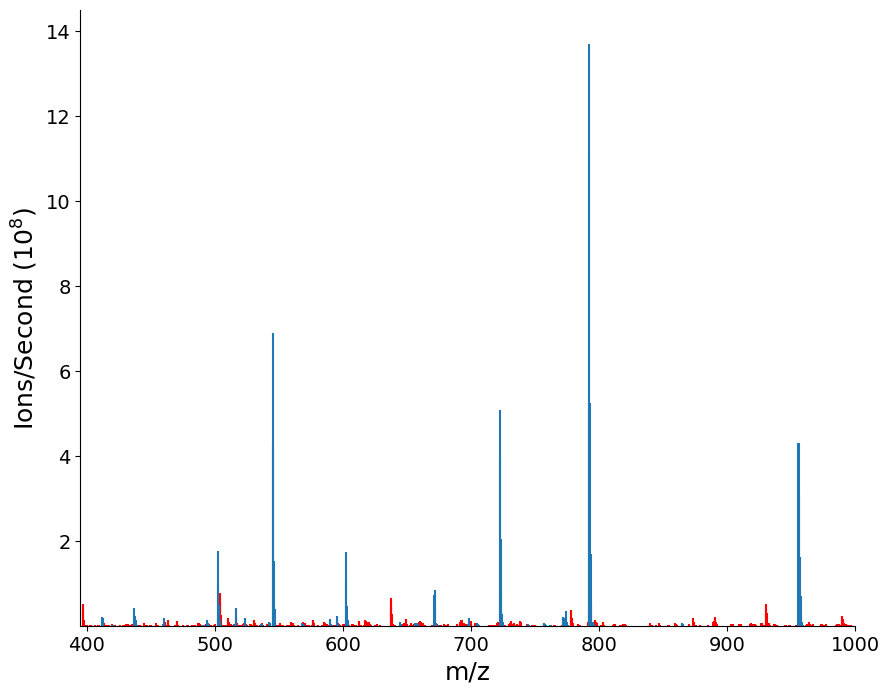

In [50]:
# define figure size
plt.figure(figsize=(10,8))

# plot spectra
plt.vlines(x= noid_ms1_peaks["mz"], ymin = 0, ymax = noid_ms1_peaks["ips"]/1e8, color="red")
plt.vlines(x= id_ms1_peaks["mz"], ymin = 0, ymax = id_ms1_peaks["ips"]/1e8, color="#1f77b4")

# set x-axis parameters
plt.xlabel("m/z", fontsize=18)
plt.xlim(395,1000)
plt.xticks(fontsize=14)

# set y-axis parameters
plt.ylabel("Ions/Second ($10^{8}$)",fontsize=18)
plt.ylim(0,14.5)
plt.yticks(np.arange(2,15,2))
plt.yticks(fontsize=14)

# despine top and right
sns.despine()

# show plot
plt.show()

In [51]:
# find most intense peaks
ms1_peaks[ms1_peaks["in_encyclo"] > 0].sort_values(by="ips", ascending=False).head(7)

,mz,ips,mass,charge,in_encyclo,in_dist
536,791.9327,1.370177e+09,1581.8505,2.0,1.0,1
195,545.3016,6.884255e+08,1088.5885,2.0,2.0,1
461,722.3533,5.071602e+08,1442.6917,2.0,1.0,1
666,955.4457,4.295609e+08,1908.8768,2.0,1.0,1
118,502.2885,1.747286e+08,1002.5623,2.0,1.0,1
285,602.3121,1.736622e+08,1202.6097,2.0,1.0,1
395,671.3362,7.167729e+07,2010.9866,3.0,1.0,1


In [52]:
# create connection
elib_connection = sqlite3.connect("panoramaweb_files/plasma-EV-01.mzML.elib")

# create empty dictionary and list for results
mz2pep_dict = {}
pep_list = []

# create list of masses
mz_list = ms1_peaks[ms1_peaks["in_encyclo"] > 0].sort_values(by="ips", ascending=False).head(7).mz

# create sql query
sql = """SELECT PeptideSeq
		 FROM entries
		 WHERE ((3460.398 BETWEEN RTInSecondsStart AND RTInSecondsStop) AND ((PrecursorMz - ?) BETWEEN -0.01 AND 0.01));"""

# print the protein(s) associated with each peptide sequence
for mz in mz_list:
	sql_df = pd.read_sql_query(sql, elib_connection, params=[mz])
	for pep in sql_df["PeptideSeq"]:
		if mz in mz2pep_dict.keys():
			mz2pep_dict[mz].append(pep)
		else:
			mz2pep_dict[mz] = [pep]
		pep_list.append(pep)
		print(mz, ":", pep)

# close the database connection
elib_connection.close()

791.9327 : IQPSGGTNINEALLR
545.3016 : LLADPTGAFGK
545.3016 : LDAQASFLPK
722.3533 : LMQCLPNPEDVK
955.4457 : LLATLCSAEVCQCAEGK
502.2885 : QVVAGLNFR
602.3121 : GMTNINDGLLR
671.3362 : TFGSGEADCGLRPLFEKK


In [53]:
# create connection
elib_connection = sqlite3.connect("panoramaweb_files/plasma-EV-01.mzML.elib")

# initiate empty protein dictionary
seq2pro_dict = {}

# create sql query
sql = """SELECT ProteinAccession 
		 FROM peptidetoprotein
		 WHERE PeptideSeq = ?;"""

# print the protein(s) associated with each peptide sequence
for seq in pep_list:
	sql_df = pd.read_sql_query(sql, elib_connection, params=[seq])
	for protein in sql_df["ProteinAccession"]:
		if seq in seq2pro_dict.keys():
			seq2pro_dict[seq].append(protein)
		else:
			seq2pro_dict[seq] = [protein]		
		print(seq, ":", protein)

# close the database connection
elib_connection.close()

IQPSGGTNINEALLR : sp|P19823|ITIH2_HUMAN
LLADPTGAFGK : sp|P30044|PRDX5_HUMAN
LDAQASFLPK : sp|P19827|ITIH1_HUMAN
LMQCLPNPEDVK : sp|P04003|C4BPA_HUMAN
LLATLCSAEVCQCAEGK : sp|P0C0L4|CO4A_HUMAN
LLATLCSAEVCQCAEGK : sp|P0C0L5|CO4B_HUMAN
QVVAGLNFR : sp|P01042|KNG1_HUMAN
GMTNINDGLLR : sp|Q06033|ITIH3_HUMAN
TFGSGEADCGLRPLFEKK : sp|P00734|THRB_HUMAN


In [54]:
# combine dictionary info
for mz in mz_list:
    for pep in mz2pep_dict[mz]:
        for pro in seq2pro_dict[pep]:
            print(mz, "m/z:", pep, "("+pro+")")

791.9327 m/z: IQPSGGTNINEALLR (sp|P19823|ITIH2_HUMAN)
545.3016 m/z: LLADPTGAFGK (sp|P30044|PRDX5_HUMAN)
545.3016 m/z: LDAQASFLPK (sp|P19827|ITIH1_HUMAN)
722.3533 m/z: LMQCLPNPEDVK (sp|P04003|C4BPA_HUMAN)
955.4457 m/z: LLATLCSAEVCQCAEGK (sp|P0C0L4|CO4A_HUMAN)
955.4457 m/z: LLATLCSAEVCQCAEGK (sp|P0C0L5|CO4B_HUMAN)
502.2885 m/z: QVVAGLNFR (sp|P01042|KNG1_HUMAN)
602.3121 m/z: GMTNINDGLLR (sp|Q06033|ITIH3_HUMAN)
671.3362 m/z: TFGSGEADCGLRPLFEKK (sp|P00734|THRB_HUMAN)


## Figure (c)

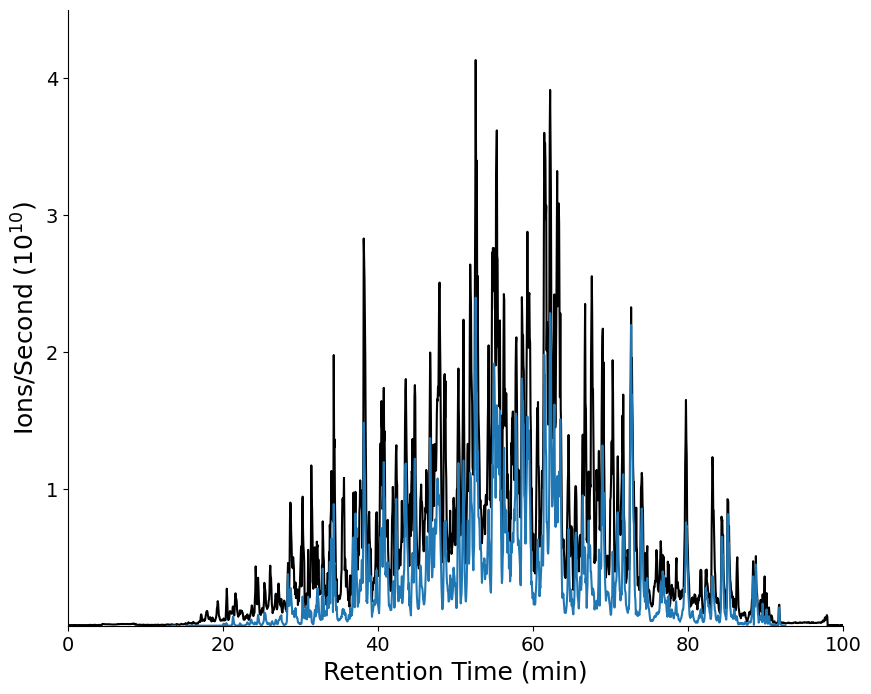

In [55]:
# create figure and axis objects with subplots()
fig, ax = plt.subplots(figsize=(10,8))

# make a TIC plot
ax.plot(joined_EV.rt_ms1, joined_EV.TIC_ms1/1e10, color="black")
ax.plot(joined_EV.rt_ms1, joined_EV.TIC_id/1e10, color="#1f77b4")

# set x-axis parameters
ax.set_xlabel("Retention Time (min)", fontsize=18)
ax.set_xlim(0,100)
plt.xticks(fontsize=14)

# set y-axis parameters
ax.set_ylabel("Ions/Second ($10^{10}$)",fontsize=18)
ax.set_ylim(0,4.5)
ax.set_yticks(np.arange(1,5,1))
plt.yticks(fontsize=14)

# despine top and right
sns.despine()

# show plot
plt.show()

## Figure (d)

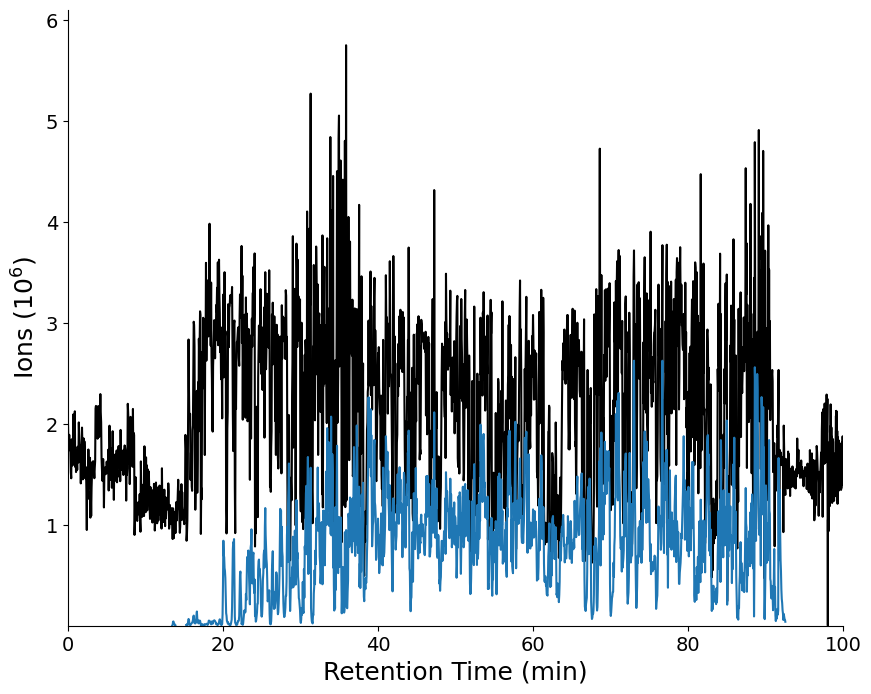

In [56]:
# create figure and axis objects with subplots()
fig, ax = plt.subplots(figsize=(10,8))

# make a plot for ion counts
ax.plot(joined_EV.rt_ms1, joined_EV.ions_ms1/1e6, color="black")
ax.plot(joined_EV.rt_ms1, joined_EV.ions_id/1e6, color="#1f77b4")

# set x-axis parameters
ax.set_xlabel("Retention Time (min)", fontsize=18)
ax.set_xlim(0,100)
plt.xticks(fontsize=14)

# set y-axis parameters
ax.set_ylabel("Ions ($10^{6}$)",fontsize=18)
ax.set_ylim(0,6.1)
ax.set_yticks(np.arange(1,7,1))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.yticks(fontsize=14)

# despine top and right
sns.despine()

# show plot
plt.show()

## Check number of persistent peptide isotope distributions in MS1

In [57]:
kro.simple_df("panoramaweb_files/plasma-EV-01_MS1_3sn.kro")

,mass,charge,best_int,sum_int,first_rt,last_rt,best_rt,mz,best_rt_s
0,2231.2478,3,1.616450e+10,1.030444e+11,72.323997,74.054100,72.6790,744.756547,4360.740
1,1560.7221,2,1.527122e+10,8.701598e+10,61.926300,63.189400,62.2799,781.368330,3736.794
2,2573.3749,4,1.432324e+10,1.039129e+11,61.320202,62.279900,61.7243,644.351005,3703.458
3,1994.0411,3,1.405554e+10,7.087979e+10,66.539398,67.202599,66.7443,665.687647,4004.658
4,2993.4495,4,1.331302e+10,8.374138e+10,62.684200,64.558701,63.1388,749.369655,3788.328
...,...,...,...,...,...,...,...,...,...
19094,751.7991,1,1.136700e+04,6.143600e+04,3.919700,4.228900,3.9713,752.806380,238.278
19095,867.7536,2,1.124100e+04,3.639250e+04,1.243600,1.397900,1.3465,434.884080,80.790
19096,867.7521,2,1.115300e+04,3.075100e+04,3.816500,3.919700,3.8165,434.883330,228.990
19097,678.0170,1,1.091600e+04,3.656400e+04,3.764700,3.971300,3.9713,679.024280,238.278
